In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

In [24]:
df = pd.read_csv('./data/elements.csv', encoding='utf-8')
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2708 entries, 0 to 2707
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   page       2708 non-null   int64  
 1   record_no  2708 non-null   int64  
 2   start_x    2708 non-null   float64
 3   start_y    2708 non-null   float64
 4   end_x      2708 non-null   object 
 5   end_y      2708 non-null   float64
 6   text       2708 non-null   object 
 7   font       2708 non-null   object 
 8   size       2708 non-null   int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 190.5+ KB
None
page         0
record_no    0
start_x      0
start_y      0
end_x        0
end_y        0
text         0
font         0
size         0
dtype: int64


In [25]:
regex = r'^\d+(\.\d+)?%?$'

# Validate and convert the 'end_x' column to a float type
for i, value in enumerate(df['end_x']):
    if not isinstance(value, str):
        print(value)
        continue
    if not re.match(regex, value):
        print(value)
        df.at[i, 'end_x'] = np.nan
    else:
        try:
            df.at[i, 'end_x'] = float(value)
                
        except ValueError:
            print(value)
            df.at[i, 'end_x'] = float(value.replace('%', '')) / 100

53303%
10771%
10147%
53838%
32497%
53770%
54633%
47498%
52057%
31158%
53372%
53441%
18740%
53929%
9733%
53128%
31648%
51348%
54132%
31158%
52863%
52474%
37362%
22339%
50118%
52938%
53723%
52257%
34038%
50695%
53082%
51153%
53170%
50745%
51377%
52337%
16829%
50666%
54918%
22402%
55748%
34987%
40345%
56911%
17354%
47358%
32902%
40018%
57076%
16611%
27835%
45225%
12310%
45223%
16854%
31861%
53670%
38454%
53670%
31848%
38454%
24108%
38455%
45212%
23994%
45212%
38592%
53712%
41777%
24718%
31158%
13084%
50917%
31897%
13484%
25274%
45614%
20389%
32077%
6-Sep-00
9-Nov-00
19-Jan-01
51229%
52562%
54677%
50781%
52811%
50795%
55021%
55488%
54292%
51657%
29515%
40975%
30391%
47408%
11719%
25318%
36365%
41973%
30392%
41971%
47409%
47411%
41666%
25604%
31574%
37537%
49147%
55531%
31579%
37545%
43513%
49152%
55445%
27594%
53385%
18080%
23780%
23942%
29733%
41485%
53545%
15652%
31039%
48950%
54492%
36792%
54559%
50591%
52098%
31446%
26238%
53721%
20949%
25556%
44761%
20293%
25034%
39320%
38330%
15802%


In [26]:
df = df.dropna()
df['end_x'] = df['end_x'].astype('float64')

In [27]:
def classify_element(page, record_no, start_x, start_y, end_x, end_y, text, font, size):
    # Rule for cover page
    if page == 0:
        if (size > 9) and ('Bold' in font) and (not 20 <= record_no <= 24):
            return "Title"
        elif (20 <= record_no <= 24) or (record_no == 12):
            return "Other"
        else:
            return "Paragraph"

    # Rule-based classification for Numbering
    if (text == str(page)) or ((text.startswith("*") or (text.split()[0][0] == "(" and text.split()[0][-1] == ")") or (text.startswith("-")) and (len(text) == 2) and (start_x < 320))):
        return "Numbering"
    # --> update later to classify footer reference line after line that starts with "(digit)"
    
    # Rule-based classification for Table
    if (size <= 10 and (not (text.startswith("*") or (text.startswith("")))) and len(text) < 60 and "." not in text) or (start_x > 100 and size <= 10):
        return "Table"

    # Rule-based classification for Numbering (bullet points in page 1-2) --> text below the first line that starts with '' will later  be updated
    if text.startswith('') and len(text) > 1:
        return "Numbering" 
    # Rule-based classification for Title (not a bullet point)
    elif ('Bold' in font or font == 'TimesNewRomanPS-ItalicMT') and (size >= 11):
        return "Title"

    # Rule-based classification for Paragraph
    if (font == 'TimesNewRomanPSMT' and size == 11):
        return "Paragraph"

    
    # Default classification as "Other"
    return "Other"

df['category'] = df.apply(lambda row: classify_element(row['page'], row['record_no'], row['start_x'], row['start_y'], row['end_x'], row['end_y'], row['text'], row['font'], row['size']), axis=1)

In [28]:
# Update category value to Numbering for foot references that do not startswith "(digit)"
df.loc[(df['category'] == 'Other') & (df['size'] <= 9), 'category'] = 'Numbering'
# Update category value to Numbering for bullet points in page 1 and 2 that do not startswith ''
df.loc[(df['category'] == 'Paragraph') & (df['page'] == 1) & (df.index >= 52), 'category'] = 'Numbering'
df.loc[(df['category'] == 'Paragraph') & (df['page'] == 2) & (df.index <= 70), 'category'] = 'Numbering'

In [29]:
df.head()

,page,record_no,start_x,start_y,end_x,end_y,text,font,size,category
0,0,0,48.439,735.1856,531.559,745.7156,Hong Kong Exchanges and Clearing Limited and T...,MAGMOF+TimesLTStd-Roman,10,Paragraph
1,0,1,48.439,723.1856,531.809,733.7156,Stock Exchange”) take no responsibility for th...,MAGMOF+TimesLTStd-Roman,10,Paragraph
2,0,2,48.439,711.1856,546.129,721.1856,accuracy or completeness and expressly disclai...,MAGMOF+TimesLTStd-Roman,10,Paragraph
3,0,3,48.439,699.1856,363.549,709.1856,reliance upon the whole or any part of the con...,MAGMOF+TimesLTStd-Roman,10,Paragraph
4,0,4,48.439,675.1856,510.579,685.1856,"We have one class of shares, and each holder o...",MAGMOF+TimesLTStd-Roman,10,Paragraph


In [30]:
df.to_csv('classified_elements.csv', index=False)

In [32]:
df = pd.read_csv("classified_elements.csv", encoding='UTF-8')

# Define a function to extract features from each text element
def extract_features(df):
    # Initialize empty lists for each feature
    text_length = []
    num_words = []
    bold_font = []
    italic_font = []
    is_digit = []
    # Iterate over each row in the DataFrame
    for i, row in df.iterrows():
        # Extract the text for this element
        text = row['text']
        # Extract the length of the text
        text_length.append(len(text))
        # Extract the number of words in the text
        num_words.append(len(text.split()))
        # Check if the font is bold or italic
        bold = 0
        italic = 0
        if 'Bold' in row['font']:
            bold = 1
        if 'Italic' in row['font']:
            italic = 1
        bold_font.append(bold)
        italic_font.append(italic)
        # Check if the text is a thousands value (e.g. "39,560")
        thousands_regex = r'^\d{1,3}(,\d{3})*$'
        percent_regex = r'^\d+(\.\d+)?%$'
        # Check if the text is an integer
        if text.isdigit() or re.match(thousands_regex, text) or re.match(percent_regex, text):
            is_digit.append(1)
        else:
            is_digit.append(0)
    # Create a new DataFrame with the extracted features
    features_df = pd.DataFrame({'text_length': text_length,
                                'num_words': num_words,
                                'bold_font': bold_font,
                                'italic_font': italic_font,
                                'is_digit': is_digit})
    
    # Concatenate the original DataFrame with the new features DataFrame
    df = pd.concat([df, features_df], axis=1)
    return df.drop('font', axis=1)

# Call the extract_features function on the dataset
df = extract_features(df)

# Print the updated DataFrame
df2 = df.copy()
df2

,page,record_no,start_x,start_y,end_x,end_y,text,size,category,text_length,num_words,bold_font,italic_font,is_digit
0,0,0,48.43900,735.18560,531.559,745.71560,Hong Kong Exchanges and Clearing Limited and T...,10,Paragraph,100,17,0,0,0
1,0,1,48.43900,723.18560,531.809,733.71560,Stock Exchange”) take no responsibility for th...,10,Paragraph,111,17,0,0,0
2,0,2,48.43900,711.18560,546.129,721.18560,accuracy or completeness and expressly disclai...,10,Paragraph,114,17,0,0,0
3,0,3,48.43900,699.18560,363.549,709.18560,reliance upon the whole or any part of the con...,10,Paragraph,73,13,0,0,0
4,0,4,48.43900,675.18560,510.579,685.18560,"We have one class of shares, and each holder o...",10,Paragraph,108,22,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2700,36,58,378.76616,434.76331,395.000,444.19031,846,9,Table,3,1,0,0,1
2701,36,59,426.52900,434.76331,443.000,444.19031,874,9,Table,3,1,0,0,1
2702,36,60,474.29183,434.76331,490.750,444.19031,881,9,Table,3,1,0,0,1
2703,36,61,526.19407,434.76331,542.650,444.19031,902,9,Table,3,1,0,0,1


Text(0.5, 0, 'Number of ocurrences')

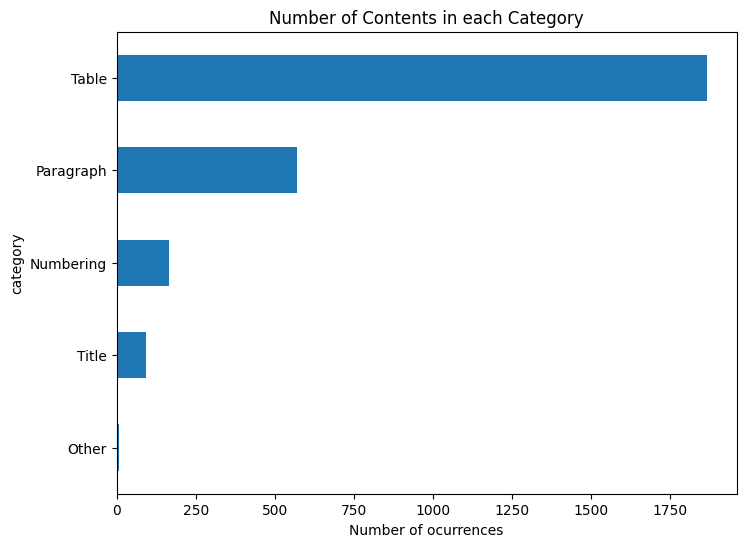

In [33]:
# Visualize count of each category
fig = plt.figure(figsize=(8,6))
df2.groupby('category')['category'].count().sort_values().plot.barh(
    ylim=0, title= 'Number of Contents in each Category')
plt.xlabel('Number of ocurrences', fontsize = 10)

In [34]:
# Convert the target variable to numerical labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['category'])

# Print the label mapping
map_cat = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(map_cat)

# Vectorize text and reduce dimension using SVD
tfidf = TfidfVectorizer(sublinear_tf=True,
                        ngram_range=(1, 2), 
                        stop_words='english')

text_vec = tfidf.fit_transform(df['text']).toarray()
print(f"before reduced: {text_vec.shape}")

svd = TruncatedSVD(n_components=100)
text_vec = svd.fit_transform(text_vec)
print(f"after reduced: {text_vec.shape}")

text_vec_df = pd.DataFrame(text_vec)
df2 = pd.concat([df.drop(['text', 'category'], axis=1), text_vec_df], axis=1)
df2.columns = df2.columns.astype(str)

X = df2.copy()

# Split data into train, val, test set using stratify to make sure
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=0, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=0, stratify=y_train_val)
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

# Scaling the data using RobustScaler since there could be outliers
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

{'Numbering': 0, 'Other': 1, 'Paragraph': 2, 'Table': 3, 'Title': 4}
before reduced: (2705, 5543)
after reduced: (2705, 100)
Training set: (1893, 112), (1893,)
Validation set: (406, 112), (406,)
Testing set: (406, 112), (406,)


In [35]:
print(np.unique(y, return_counts=True))
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1, 2, 3, 4]), array([ 165,    9,  571, 1866,   94], dtype=int64))
(array([0, 1, 2, 3, 4]), array([ 115,    7,  399, 1306,   66], dtype=int64))
(array([0, 1, 2, 3, 4]), array([ 25,   1,  86, 280,  14], dtype=int64))
(array([0, 1, 2, 3, 4]), array([ 25,   1,  86, 280,  14], dtype=int64))


In [36]:
# Functions to calculate precision, recall, and f1 score
def score_metrics(y_true, y_pred):
    metrics = precision_recall_fscore_support(y_true, y_pred, average='macro')
    performance = {'precision': metrics[0], 'recall': metrics[1], 'f1': metrics[2]}
    return performance

def score_metrics_df(y_true, y_pred, index):
    metrics = precision_recall_fscore_support(y_true, y_pred, average='macro')
    performance = {'precision': metrics[0], 'recall': metrics[1], 'f1': metrics[2]}
    return pd.DataFrame(performance, index=[index])

In [37]:
# Define several models to do the initial model building
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    LogisticRegression(random_state=0),
    XGBClassifier(),
    LGBMClassifier()
]
# Define the cross-validation procedure
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

cv_df = pd.DataFrame(index=range(CV.get_n_splits() * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    # Use cross_val_score to evaluate the model
    scores = cross_val_score(model, X_train, y_train, cv=CV)
    print(scores)
    # Compute the scores for each metric using the score function you defined
    for fold_idx, score in enumerate(scores):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_true = y_val
        performance = score_metrics(y_true, y_pred)
        entries.append((model_name, fold_idx, performance['precision'], performance['recall'], performance['f1'], score))
        
# Store the results in a DataFrame
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'precision', 'recall', 'f1', 'accuracy'])
# Print the results
res = cv_df.groupby('model_name').mean().sort_values(['precision', 'recall', 'f1', 'accuracy'], ascending=[False, False, False, False])
res

RandomForestClassifier
[0.94459103 0.9762533  0.95514512 0.95502646 0.96031746]
LinearSVC
[0.87335092 0.87598945 0.88918206 0.91534392 0.92592593]
LogisticRegression
[0.73614776 0.78364116 0.71503958 0.74867725 0.82804233]
XGBClassifier
[0.97889182 0.99208443 0.99472296 0.9973545  0.98412698]
LGBMClassifier
[0.98416887 0.99472296 0.99736148 0.9973545  0.98677249]


,fold_idx,precision,recall,f1,accuracy
model_name,,,,,
LGBMClassifier,2.0,0.781997,0.769714,0.775513,0.992076
XGBClassifier,2.0,0.781997,0.769714,0.775513,0.989436
RandomForestClassifier,2.0,0.767122,0.570857,0.609163,0.958267
LinearSVC,2.0,0.628405,0.614220,0.616649,0.895958
LogisticRegression,2.0,0.387285,0.361462,0.370839,0.762310


In [38]:
# Choose XGBoost since more familiar to the hyperparameters
xgbc = XGBClassifier()

# Fit the model to the training data
xgbc.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = xgbc.predict(X_test)

# Calculate the performance metrics
result_df = score_metrics_df(y_test, y_pred, 'Base')

result_df

,precision,recall,f1
Base,0.799288,0.8,0.799643


In [39]:
xgbc.get_params()

{'objective': 'multi:softprob',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

              precision    recall  f1-score   support

   Numbering       1.00      1.00      1.00        25
       Other       0.00      0.00      0.00         1
   Paragraph       1.00      1.00      1.00        86
       Table       1.00      1.00      1.00       280
       Title       1.00      1.00      1.00        14

    accuracy                           1.00       406
   macro avg       0.80      0.80      0.80       406
weighted avg       1.00      1.00      1.00       406



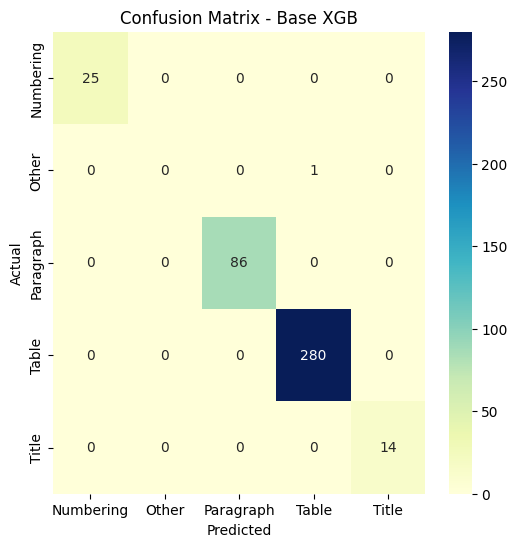

In [40]:
def plot_result(y_test, y_pred, model_name):
    print(metrics.classification_report(y_test, y_pred, 
                                        target_names= map_cat.keys()))

    y_test_label = label_encoder.inverse_transform(y_test)
    y_pred_label = label_encoder.inverse_transform(y_pred)

    cm = confusion_matrix(y_test_label, y_pred_label)
    fig, ax = plt.subplots(figsize=(6,6))
    sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt='d',
                xticklabels=map_cat.keys(), 
                yticklabels=map_cat.keys())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f"Confusion Matrix - {model_name}", size=12)
    plt.show()

# Visualize confusion matrix of the results
plot_result(y_test, y_pred, "Base XGB")

In [41]:
# Define the hyperparameters to tune and their ranges
param_distributions = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'subsample': [0, 0.6, 0.8],
    'colsample_bytree': [0, 0.6, 0.8],
    'gamma': [-1, 0, 1, 3],
    'reg_alpha': [-1, 0, 10, 20],
    'reg_lambda': [-1, 0, 0.1, 0.5],
    'min_child_weight': [0, 1, 3, 5]
}

model = XGBClassifier()
# Define the randomized search
random_search = RandomizedSearchCV(model, param_distributions=param_distributions, n_iter=50, cv=CV, scoring='f1_macro', random_state=0)
random_search.fit(X_train, y_train)
print("Best hyperparameters:", random_search.best_params_)

# Create a new model with the best hyperparameters
best_model = XGBClassifier(**random_search.best_params_)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

tuned_df = score_metrics_df(y_test, y_pred, 'Tuned')
result_df = pd.concat([result_df, tuned_df])

Best hyperparameters: {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 0, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}


In [42]:
result_df # After hyperparameter tuning it turns out it does not improve the base model

,precision,recall,f1
Base,0.799288,0.8,0.799643
Tuned,0.799288,0.8,0.799643


In [13]:
# Save base model
pickle.dump(xgbc, open("xgb_classifier.pkl", "wb"))